In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from itertools import compress
from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold()

In [2]:
df3 = pd.read_csv('info4.csv')
df3 = df3.drop(columns = ['Unnamed: 0'], axis = 1)

In [3]:
df = pd.read_csv('merged tables2.csv')
df = df.drop(columns = ['Unnamed: 0'], axis = 1)
df = df.dropna(axis=0).reset_index(drop=True)
df = df.drop_duplicates()

In [4]:
df['avg_axle'] = df[['axle1_rf','axle1_lf', 
                                   'axle2_rf', 'axle2_lf', 'axle3_rf', 'axle3_lf', 
                                   'axle4_rf','axle4_lf']].mean(numeric_only=True, axis=1)

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df=df.sort_values(by=['operDate'])
df["operDate"] = le.fit_transform(df["operDate"])
df=df.sort_values(by=['msr_date'])
df["msr_date"] = le.fit_transform(df["msr_date"])
df

,carNum,operDate,operSt,operDestSt,operCargo,operWeight,real_dist,passed_dist,was_in_rep,msr_date,...,axle2_rf,axle2_lf,axle3_rf,axle3_lf,axle4_rf,axle4_lf,days_in_operation,n_times_parts_in_repair,days_after_last_inspection,avg_axle
26696,59168815,13,4920,2190,10307,45.0,455.0,935,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5940,40,1265,28.7250
26698,59168815,27,4920,2190,10307,45.0,455.0,562,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5954,40,1279,28.7250
26697,59168815,19,2170,4930,42100,0.0,456.0,1357,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5946,40,1271,28.7250
26694,59168815,4,4930,2190,10307,45.0,483.0,1147,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5931,40,1256,28.7250
26695,59168815,9,2170,4930,42100,0.0,456.0,1375,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5936,40,1261,28.7250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19740,94591799,30,71120,70850,300,60.0,872.0,208,0,383,...,26.8,27.8,26.7,28.7,27.5,28.5,2400,20,1,27.9875
8196,52761947,30,20010,86230,23245,0.0,3911.0,328,0,384,...,28.4,27.1,28.1,29.3,28.5,27.2,5894,120,0,27.7750
28643,53569968,30,20010,86230,23245,0.0,3911.0,328,0,384,...,28.2,28.0,26.7,29.2,26.1,28.7,6206,80,0,27.6875
7602,61554911,30,20010,86230,23245,0.0,3911.0,328,0,384,...,28.2,27.3,27.5,27.0,26.7,27.4,3106,80,0,27.5125


In [6]:
operDestSt_nom = (df.groupby('operDestSt').size()) / len(df)
df['operDestSt'] = df['operDestSt'].apply(lambda x : operDestSt_nom[x])
operSt_nom = (df.groupby('operSt').size()) / len(df)
df['operSt'] = df['operSt'].apply(lambda x : operSt_nom[x])
operCargo_nom = (df.groupby('operCargo').size()) / len(df)
df['operCargo'] = df['operCargo'].apply(lambda x : operCargo_nom[x])

In [7]:
columns_for_X=[ 'operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight',
       'real_dist', 'passed_dist', 'msr_date', 'axle1_rf',
       'axle1_lf', 'axle2_rf', 'axle2_lf', 'axle3_rf', 'axle3_lf', 'axle4_rf',
       'axle4_lf', 'days_in_operation', 'n_times_parts_in_repair',
       'days_after_last_inspection','avg_axle']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[columns_for_X], df.was_in_rep, test_size=0.33, random_state=42)

In [9]:
y_train.value_counts()

0    19277
1      631
Name: was_in_rep, dtype: int64

In [10]:
y_test.value_counts()

0    9522
1     284
Name: was_in_rep, dtype: int64

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=10)

In [12]:
y_train.value_counts()

0    17351
1      566
Name: was_in_rep, dtype: int64

In [13]:
y_val.value_counts()

0    1926
1      65
Name: was_in_rep, dtype: int64

In [14]:
def info(y_test,y_pred,y_pred_proba):
    confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('tn:',tn)
    print('fp:',fp)
    print('fn:',fn)
    print('tp:',tp)
    print(fr'Accuracy: {100 * accuracy_score(y_test, y_pred):.3f} %')
    print(fr'Roc_auc: { roc_auc_score(y_test, y_pred_proba):.3f} ')

In [15]:
def info_for_df(y_test,y_pred_proba):
    confusion_matrix(y_test, y_pred_proba)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proba).ravel()
    return ([tn, fp, fn, tp,100 * accuracy_score(y_test, y_pred_proba),f1_score(y_test, y_pred_proba),roc_auc_score(y_test, y_pred_proba)])

In [16]:
df=pd.DataFrame( columns=['Model', 'TN', 'FP', 'FN', 'TP', 'Accuracy','F1','Roc_auc'])
df

,Model,TN,FP,FN,TP,Accuracy,F1,Roc_auc


# XGBoost FeatureSelector

In [17]:
import xgboost as xgb
col=['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'axle1_lf', 'days_after_last_inspection']

xgbr = xgb.XGBClassifier()
xgbr.fit(X_train[col], y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [18]:
lst = np.arange(0.1, 0.9, 0.005)
df=pd.DataFrame( columns=['threshold', 'TN', 'FP', 'FN', 'TP', 'Accuracy','F1','Roc_auc'])

for i in lst:
    threshold = i
    y_pred_proba = (xgbr.predict_proba(X_val[col])[:, 1]>= threshold).astype('float')
    y_pred = xgbr.predict(X_val[col])

    res = info_for_df(y_val,y_pred_proba)
    df=df.append({'threshold':i, 'TN':res[0], 'FP':res[1], 
                  'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5], 'Roc_auc':res[6]}, ignore_index=True)   

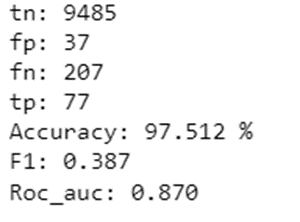# 

In [19]:
df[(df.threshold>0.496)&(df.threshold<0.505)]

,threshold,TN,FP,FN,TP,Accuracy,F1,Roc_auc
80,0.5,1920.0,6.0,54.0,11.0,96.986439,0.268293,0.583058


In [20]:
df[df.FP<df.TP].sort_values(by=['FN'])[:50]

,threshold,TN,FP,FN,TP,Accuracy,F1,Roc_auc
36,0.280,1909.0,17.0,47.0,18.0,96.785535,0.360000,0.634048
37,0.285,1909.0,17.0,47.0,18.0,96.785535,0.360000,0.634048
38,0.290,1909.0,17.0,47.0,18.0,96.785535,0.360000,0.634048
39,0.295,1910.0,16.0,47.0,18.0,96.835761,0.363636,0.634308
40,0.300,1910.0,16.0,48.0,17.0,96.785535,0.346939,0.626616
41,0.305,1910.0,16.0,48.0,17.0,96.785535,0.346939,0.626616
42,0.310,1910.0,16.0,48.0,17.0,96.785535,0.346939,0.626616
43,0.315,1910.0,16.0,48.0,17.0,96.785535,0.346939,0.626616
44,0.320,1911.0,15.0,48.0,17.0,96.835761,0.350515,0.626875
45,0.325,1911.0,15.0,48.0,17.0,96.835761,0.350515,0.626875


In [21]:
df[40:80]

,threshold,TN,FP,FN,TP,Accuracy,F1,Roc_auc
40,0.300,1910.0,16.0,48.0,17.0,96.785535,0.346939,0.626616
41,0.305,1910.0,16.0,48.0,17.0,96.785535,0.346939,0.626616
42,0.310,1910.0,16.0,48.0,17.0,96.785535,0.346939,0.626616
43,0.315,1910.0,16.0,48.0,17.0,96.785535,0.346939,0.626616
44,0.320,1911.0,15.0,48.0,17.0,96.835761,0.350515,0.626875
45,0.325,1911.0,15.0,48.0,17.0,96.835761,0.350515,0.626875
46,0.330,1911.0,15.0,49.0,16.0,96.785535,0.333333,0.619183
47,0.335,1911.0,15.0,49.0,16.0,96.785535,0.333333,0.619183
48,0.340,1911.0,15.0,49.0,16.0,96.785535,0.333333,0.619183
49,0.345,1911.0,15.0,49.0,16.0,96.785535,0.333333,0.619183


In [22]:
lst = np.arange(0.1, 0.9, 0.005)
df11=pd.DataFrame( columns=['threshold', 'TN', 'FP', 'FN', 'TP', 'Accuracy','F1','Roc_auc'])

for i in lst:
    threshold = i
    y_pred_proba = (xgbr.predict_proba(X_test[col])[:, 1]>= i).astype('float')
    y_pred = xgbr.predict(X_test[col])


    res = info_for_df(y_test,y_pred_proba)
    df11=df11.append({'threshold':i, 'TN':res[0], 'FP':res[1], 
                      'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5], 'Roc_auc':res[6]}, ignore_index=True)    

In [23]:
df11[53:]

,threshold,TN,FP,FN,TP,Accuracy,F1,Roc_auc
53,0.365,9459.0,63.0,193.0,91.0,97.389353,0.415525,0.656903
54,0.370,9460.0,62.0,194.0,90.0,97.389353,0.412844,0.655195
55,0.375,9461.0,61.0,194.0,90.0,97.399551,0.413793,0.655248
56,0.380,9463.0,59.0,194.0,90.0,97.419947,0.415704,0.655353
57,0.385,9464.0,58.0,195.0,89.0,97.419947,0.412993,0.653645
...,...,...,...,...,...,...,...,...
155,0.875,9521.0,1.0,255.0,29.0,97.389353,0.184713,0.551004
156,0.880,9521.0,1.0,258.0,26.0,97.358760,0.167203,0.545722
157,0.885,9521.0,1.0,258.0,26.0,97.358760,0.167203,0.545722
158,0.890,9521.0,1.0,258.0,26.0,97.358760,0.167203,0.545722


In [24]:
df11[df11.FP<df11.TP].sort_values(by=['FN'])[:50]

,threshold,TN,FP,FN,TP,Accuracy,F1,Roc_auc
32,0.260,9418.0,104.0,179.0,105.0,97.114012,0.425963,0.679398
33,0.265,9421.0,101.0,181.0,103.0,97.124210,0.422131,0.676035
34,0.270,9422.0,100.0,181.0,103.0,97.134408,0.422998,0.676087
35,0.275,9427.0,95.0,182.0,102.0,97.175199,0.424116,0.674589
36,0.280,9429.0,93.0,182.0,102.0,97.195595,0.425887,0.674694
37,0.285,9431.0,91.0,183.0,101.0,97.205792,0.424370,0.673038
38,0.290,9434.0,88.0,184.0,100.0,97.226188,0.423729,0.671435
39,0.295,9437.0,85.0,185.0,99.0,97.246584,0.423077,0.669832
40,0.300,9437.0,85.0,185.0,99.0,97.246584,0.423077,0.669832
41,0.305,9438.0,84.0,187.0,97.0,97.236386,0.417204,0.666364


In [25]:
df12=pd.DataFrame( columns=['threshold', 'TN', 'FP', 'FN', 'TP', 'Accuracy','F1','Roc_auc'])
y_pred_proba = (xgbr.predict_proba(X_test[col])[:, 1]>= 0.36).astype('float')
y_pred = xgbr.predict(X_test[col])


res = info_for_df(y_test,y_pred_proba)
df12=df12.append({'threshold':0.36, 'TN':res[0], 'FP':res[1], 
                  'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5], 'Roc_auc':res[6]}, ignore_index=True)   

In [26]:
roc_auc_score(y_test, xgbr.predict_proba(X_test[col])[:, 1])

0.8729953761637246

In [27]:
df12

,threshold,TN,FP,FN,TP,Accuracy,F1,Roc_auc
0,0.36,9455.0,67.0,193.0,91.0,97.348562,0.411765,0.656693


In [28]:
df4=pd.DataFrame( columns=['threshold', 'TN', 'FP', 'FN', 'TP', 'Accuracy','F1'])
a=list(df3[df3.Model=='XGBClassifier SFS (backward)'].values[0][1:7])
a.insert(0, 0.500)
df4.loc[len(df4.index)]=a
df4.loc[len(df4.index)]=df.iloc[52]
df4['Model'] = 'XGBClassifier SFS (backward)'
df4

,threshold,TN,FP,FN,TP,Accuracy,F1,Model
0,0.50,9485,37,207,77,97.512 %,0.387000,XGBClassifier SFS (backward)
1,0.36,1913.0,13.0,50.0,15.0,96.835761,0.322581,XGBClassifier SFS (backward)
